### Kehua Chu (uid: 806153163)
##### Due:  Thu, Feb 22, 6pm in Bruinlearn

### Import Module

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTENC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import precision_score, recall_score, f1_score
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

### Problem 1
### (i) Derive the gradient of the prediction y_hat w.r.t. the weights w = (w0, w1, w2). Show that the gradient w.r.t. wk, where k ∈ {0, 1, 2}, only depends on outputs and weights of layers ℓ ≥ k (ℓ = 0 is the input layer). [This is what allows backpropagation in NNs.]

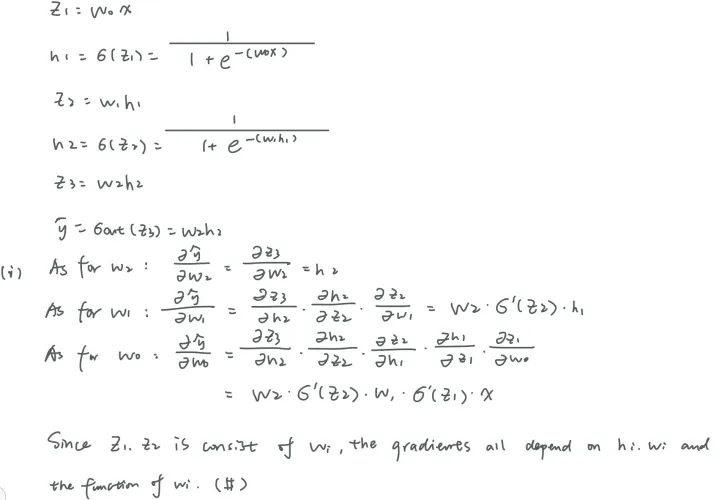

### (ii) Consider a 1-layer NN obtained by removing one of the hidden layers from the 2-layer NN above. Suppose the true data generating process is y = σ(x), where x ∼ N(0, 1). Generate n = 1, 000, 000 data points and fit both NNs by minimizing the average squared loss (you need not use backpropagation here; use scipy.optimize.minimize). Report training errors and optimized weights. Explain why in this case adding another layer increases the training error.

In [11]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [12]:
def forward_pass(x, w):
    h1 = sigmoid(w[0] * x)
    y_hat = w[1] * h1
    return y_hat

In [13]:
def forward_pass_2(x, w):
    h1 = sigmoid(w[0] * x)
    h2 = sigmoid(w[1] * h1)  
    y_hat = w[2] * h2
    return y_hat

In [14]:
def loss(w, x, y):
    y_pred = forward_pass(x, w)
    return np.mean((y_pred - y)**2)

In [15]:
def loss_2(w, x, y):
    y_pred = forward_pass_2(x, w)
    return np.mean((y_pred - y)**2)

In [16]:
np.random.seed(0)
n = 1000000
x = np.random.normal(0, 1, n)
y_true = sigmoid(x)

In [17]:
# Train 2-layer neural network
w_init = np.random.randn(3)
result_2_layer = minimize(loss_2, w_init, args=(x, y_true), method='BFGS')
w_2_layer = result_2_layer.x
training_error_2_layer = result_2_layer.fun

In [18]:
# Train 1-layer neural network
w_init_1_layer = np.random.randn(2)
result_1_layer = minimize(loss, w_init_1_layer, args=(x, y_true), method='BFGS')
w_1_layer = result_1_layer.x
training_error_1_layer = result_1_layer.fun

In [19]:
# Report results
print("1-Layer Neural Network:")
print("Optimized weights:", w_1_layer)
print("Training error:", training_error_1_layer)

print('\n')

print("2-Layer Neural Network:")
print("Optimized weights:", w_2_layer)
print("Training error:", training_error_2_layer)

1-Layer Neural Network:
Optimized weights: [0.9999775  1.00001443]
Training error: 5.2839000127366466e-11


2-Layer Neural Network:
Optimized weights: [5.59467041 3.4603795  0.67314645]
Training error: 0.01007564598790727


This might because since our true data-generating process is linear ($y = σ(x)$), using a 1-NN can effectively capture this linear relationship while using a 2-NN might increase the model's complexity and lead to overfitting problem, and as a result, it might increase the training error.

### Problem 2
### Use the dataset card transdata.csv from the previous homework and maintain the same traintest split.
### Fit a feedforward neural network with two ReLU layers using stochastic gradient descent (SGD). Follow this tutorial. Experiment with the number of neurons per layer, the number of epochs, the learning rate for SGD, and the batch size for backpropagation. Report accuracy and F1 score on the test sample. Does your model perform better than a  simple decision tree from the last homework?

In [2]:
data = pd.read_csv('card_transdata-1.csv')
data_copy = data.copy()
data.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1,1,0,0,0
1,10.829943,0.175592,1.294219,1,0,0,0,0
2,5.091079,0.805153,0.427715,1,0,0,1,0
3,2.247564,5.600044,0.362663,1,1,0,1,0
4,44.190936,0.566486,2.222767,1,1,0,1,0


In [3]:
data.isnull().sum()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

In [4]:
X_train = data.drop('fraud', axis=1).iloc[:500000]
y_train = data['fraud'].iloc[:500000]
X_test = data.drop('fraud', axis=1).iloc[500000:]
y_test = data['fraud'].iloc[500000:]

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [7]:
# Create PyTorch datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [9]:
# Create the model, loss function, and optimizer
input_size = X_train_scaled.shape[1]
model = NeuralNetwork(input_size)
loss_fn = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [10]:
# Training loop
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        optimizer.zero_grad()
        output = model(X)
        loss = loss_fn(output, y.view(-1, 1))
        loss.backward()
        optimizer.step()

# Test loop
def test(dataloader, model):
    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    with torch.no_grad():
        for X, y in dataloader:
            output = model(X)
            predicted = (output > 0.5).float()
            all_predictions.extend(predicted.squeeze().tolist())
            total += y.size(0)
            correct += (predicted == y.view(-1, 1)).sum().item()
    accuracy = correct / total
    f1 = f1_score(y_true=test_dataset[:][1].numpy(), y_pred=all_predictions)
    return accuracy, f1

In [12]:
# Train the model
epochs = 10
for t in range(epochs):
    train(train_dataloader, model, loss_fn, optimizer)
    acc, f1 = test(test_dataloader, model)
    print(f"Epoch {t+1}, Accuracy: {acc}, F1 Score: {f1}")

Epoch 1, Accuracy: 0.933272, F1 Score: 0.551619405993818
Epoch 2, Accuracy: 0.944376, F1 Score: 0.594210510957425
Epoch 3, Accuracy: 0.95592, F1 Score: 0.7146408410585738
Epoch 4, Accuracy: 0.967314, F1 Score: 0.8056371528810131
Epoch 5, Accuracy: 0.960656, F1 Score: 0.7423849558681019
Epoch 6, Accuracy: 0.96705, F1 Score: 0.7878873710908832
Epoch 7, Accuracy: 0.970906, F1 Score: 0.821948323765927
Epoch 8, Accuracy: 0.969054, F1 Score: 0.792422961859916
Epoch 9, Accuracy: 0.966446, F1 Score: 0.8304788464841816
Epoch 10, Accuracy: 0.962026, F1 Score: 0.8090933770373125


In [14]:
# Evaluate the model on the test data
test_accuracy, test_f1 = test(test_dataloader, model)
print("Test Accuracy:", test_accuracy)
print("Test F1 Score:", test_f1)

Test Accuracy: 0.962026
Test F1 Score: 0.8090933770373125


The NN model is not better than the simple decision tree in last homework. As for Test F1 score, simple decision tree generates it of 0.9998 while NN model only generates 0.8090; and as for test accuracy, simple decision tree generates nearly 1/0 while NN model only generates 0.96. 